In [109]:
import os, scipy, sklearn, spacy, glob, joblib
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from helpers import *
import html2text
import markdown
from bs4 import BeautifulSoup
from scipy.spatial.distance import cdist, pdist, squareform
import nltk
# nltk.download('stopwords')
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords as sw

%matplotlib inline

In [2]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = '../data'
fname = os.path.join(datadir, 'data_wiped_scripts.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [3]:
data = pd.read_csv(fname, index_col=0)
data.dropna(inplace=True)

In [4]:
data.head()

,id,title,url,writers,genres,script,Action,Adventure,Animation,Biography,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,wiped_scripts
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,True,False,False,False,False,False,False,ten things i hate about you by karen mccullah ...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve script
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve and holding written by anthony s cipria...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,False,True,False,False,True,False,False,twelve monkeys twelve monkeys an original scre...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve years a slave written by john ridley ca...


In [5]:
genres = list(data.columns[6:-2])
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War']

In [6]:
print(len(data))

1110


## Clean scripts

In [7]:
# a = [data['genres'].values[i].split(';') for i in range(len(data))]
# a
# genres = []
# for i in a:
#     for j in i:
#         if len(j) > 1:
#             for k in j.split('.'):
#                 genres.append(k.strip())
# genres = np.unique(np.array(genres))
# #genres = pd.DataFrame({'genre':genres}).drop_duplicates().sort_values(by='genre').reset_index(drop=True)
# genres

In [8]:
# for g in genres:
#     data[g] = data['genres'].apply(lambda x: g in x)

In [9]:
# data.dropna(inplace=True)

In [10]:
# data['wiped_scripts'] = data['script'].apply(lambda x: cleanup_text(wipe_formatting(x)))

In [11]:
# data.head()

In [12]:
# data.to_csv('../data/data_wiped_scripts.csv')

## Run topic model

In [13]:
char_names = pd.read_csv('../data/act_to_char.csv',index_col=0)
char_names.head()
chars = char_names['char'].tolist()
chars = [chars[i].split(sep=' ') for i in range(len(chars))]
chars_full = []
for char in chars:
    for char_bit in char:
        chars_full.append(char_bit.lower())
exclude = chars_full
for word in sw.words('english'):
    exclude.extend(word)

In [14]:
n_topics = 150
video_wsize = 50 # sentences 
corpus = data['wiped_scripts'].values.tolist()

# vectorizer parameters
vectorizer_params = {
    'stop_words' : exclude,
    'max_df' : 0.4,
    'min_df' : 0.05
}

# topic model parameters
semantic_params = {
    'n_components' : n_topics,
    'learning_method' : 'batch',
    'random_state' : 0,
}

In [15]:
cv = CountVectorizer(**vectorizer_params)

In [16]:
counts = cv.fit_transform(corpus)

In [17]:
['ellis' in cv.get_feature_names(), 'mozart' in cv.get_feature_names(),
 'morpheus' in cv.get_feature_names(), 'paul' in cv.get_feature_names()]

[False, False, False, False]

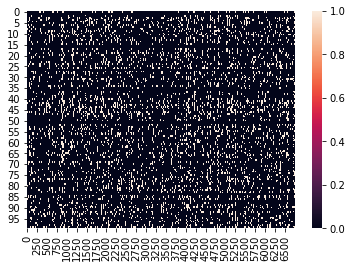

In [18]:
sns.heatmap(counts[:100,:].todense() > 0)

In [ ]:
lda = LatentDirichletAllocation(**semantic_params)
lda.fit(counts)

In [21]:
joblib.dump(lda, '../data/lda_corpus-scripts_ntopics-150.joblib')

['../data/lda_corpus-scripts_ntopics-150.joblib']

In [23]:
lda = joblib.load('../data/lda_corpus-scripts_ntopics-150.joblib')

In [24]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=150, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [25]:
weights = lda.components_.copy()
words = cv.get_feature_names()

def get_top_words(model, vocab, n_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):       
        next = topic.argsort()[:-n_words - 1:-1]
        next_words = list(map(lambda x: vocab[x], next))
        top_words.append(next_words)
        print(f'TOPIC {topic_idx}: {", ".join(next_words)}')
    return top_words

top_words = get_top_words(lda, words, 10)

TOPIC 0: rays, passageway, envelope, tug, passage, bow, wider, decks, shines, flashlight
TOPIC 1: ocean, chucks, intercut, driveway, objective, asks, spear, packages, swims, characters
TOPIC 2: vo, os, cmon, axe, fuckin, hose, revolver, program, firemen, original
TOPIC 3: childs, copper, torch, slab, generator, hunters, ridge, flashlight, foliage, viewing
TOPIC 4: filtered, engines, outer, oxygen, corridors, momentarily, ok, machinery, net, transmission
TOPIC 5: ok, images, booze, asks, photographs, footage, observes, liquid, condition, tool
TOPIC 6: ant, workers, colony, wham, insects, insect, gigantic, mound, jaws, tunnels
TOPIC 7: continuing, bobs, bills, transfer, object, spray, roses, chains, condition, reply
TOPIC 8: jar, mace, hanger, republic, highness, trade, cockpit, drain, pod, troops
TOPIC 9: pin, pins, tug, gods, chosen, brick, depot, continuous, hunters, cells
TOPIC 10: continuous, smash, footage, dish, superimpose, bin, considers, access, laden, wallet
TOPIC 11: sway, ru

## Plot movie similarity, cluster

In [26]:
data['topic_vector'] = data['wiped_scripts'].apply(lambda x: lda.transform(cv.transform([x]))[0])
data_sorted = data.sort_values(by = list(genres), ascending=False)
topic_vectors_sorted = np.vstack(data_sorted['topic_vector'])

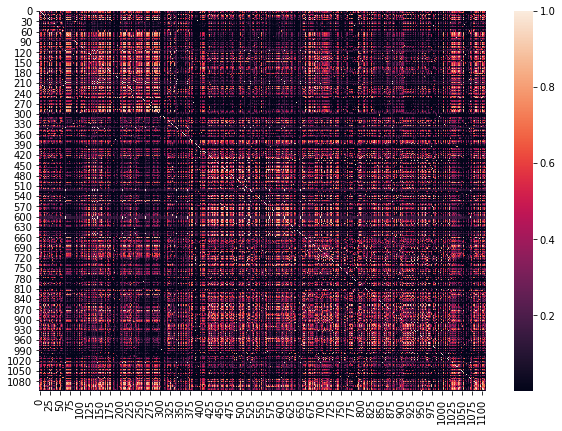

In [91]:
fig, ax = plt.subplots(1,1,figsize=[10,7])
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(topic_vectors_sorted), ax = ax)
# plt.savefig('/mnt/Cosine_similarity.pdf',bbox_inches='tight')

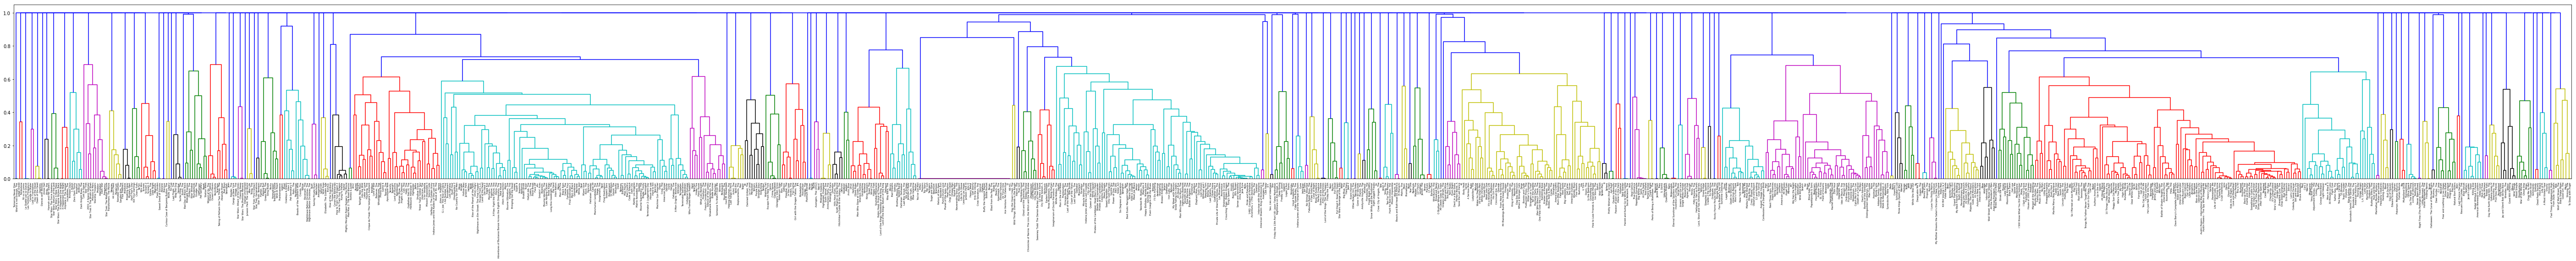

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(np.vstack(data['topic_vector']), method='complete',metric='cosine')
plt.figure(figsize=(100, 7))
dendrogram(linked, labels=data['title'].values);
plt.savefig('/mnt/Dendrogram_scripts.pdf',bbox_inches='tight')

In [78]:
from sklearn.cluster import AgglomerativeClustering
n_clust = 50
clust = AgglomerativeClustering(n_clusters=n_clust, affinity='cosine',
        memory=None, connectivity=None,
        compute_full_tree='auto', linkage='complete',
        pooling_func='deprecated')

In [79]:
out = clust.fit_predict(np.vstack(data['topic_vector']))

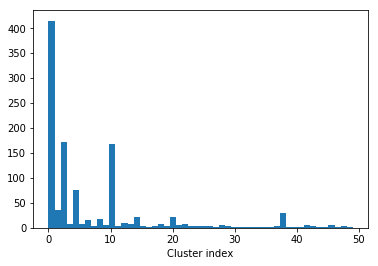

In [80]:
plt.hist(out,n_clust);
plt.xlabel('Cluster index');

In [88]:
data.loc[out==10,'title'].values

array(['12', '12 Years a Slave', '1492: Conquest of Paradise', '48 Hrs.',
       'Ace Ventura: Pet Detective', 'Air Force One', 'All About Eve',
       'Almost Famous', 'Amadeus', 'Amelia',
       'American Shaolin: King of Kickboxers II', 'Amour',
       'Anna Karenina', 'Anonymous', 'Apartment, The', 'Avengers, The',
       "Avventura, L' (The Adventure)", 'Awakenings', 'Barry Lyndon',
       'Battle of Algiers, The', 'Beach, The', 'Being Human',
       'Being There', 'Belle', 'Beloved',
       'Best Exotic Marigold Hotel, The', 'Blade II',
       'Blast from the Past, The', 'Bones', 'Bottle Rocket', 'Braveheart',
       'Broken Embraces', 'Buffy the Vampire Slayer', 'Cast Away',
       'Changeling',
       'Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
       'Cider House Rules, The', 'Cinema Paradiso', 'Citizen Kane',
       'City of Joy', 'Clash of the Titans', 'Clueless', 'Cold Mountain',
       'Copycat', 'Coriolanus', 'Creation',
       'Crouching Tiger, Hidden D

## Plot movies in topic space

<IPython.core.display.Javascript object>


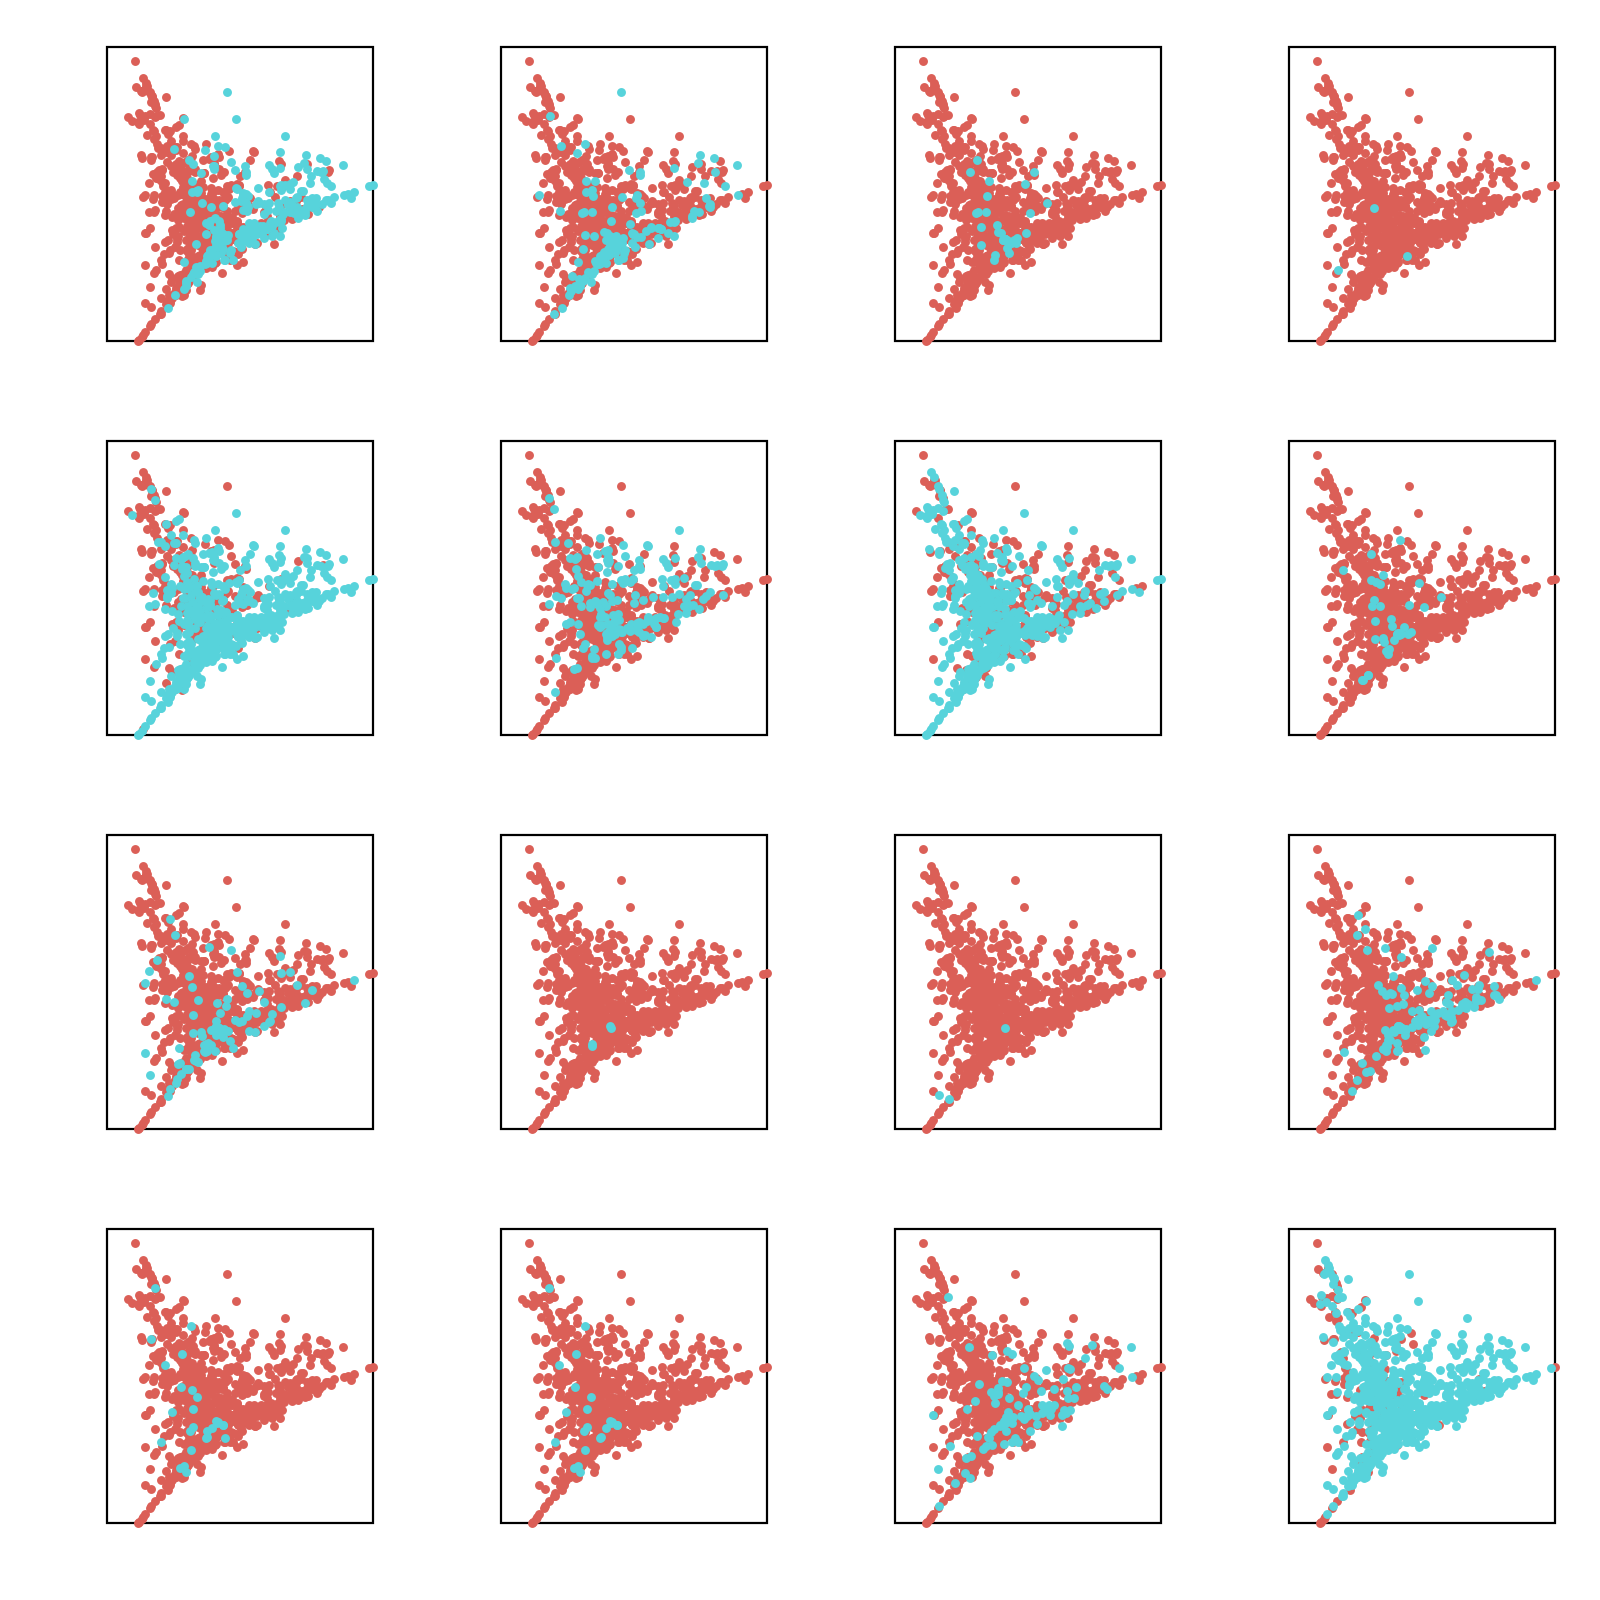

In [113]:
%matplotlib notebook
fig, ax = plt.subplots(4,4,figsize=[10,10])
ax = ax.flatten()
for ai, ax_current in enumerate(ax):
    genre_choice = genres[ai]
    hyp.plot(np.vstack(data['topic_vector']),'.', ndims=2, ax=ax_current, azim=i, hue = data[genre_choice])
plt.show()

<IPython.core.display.Javascript object>


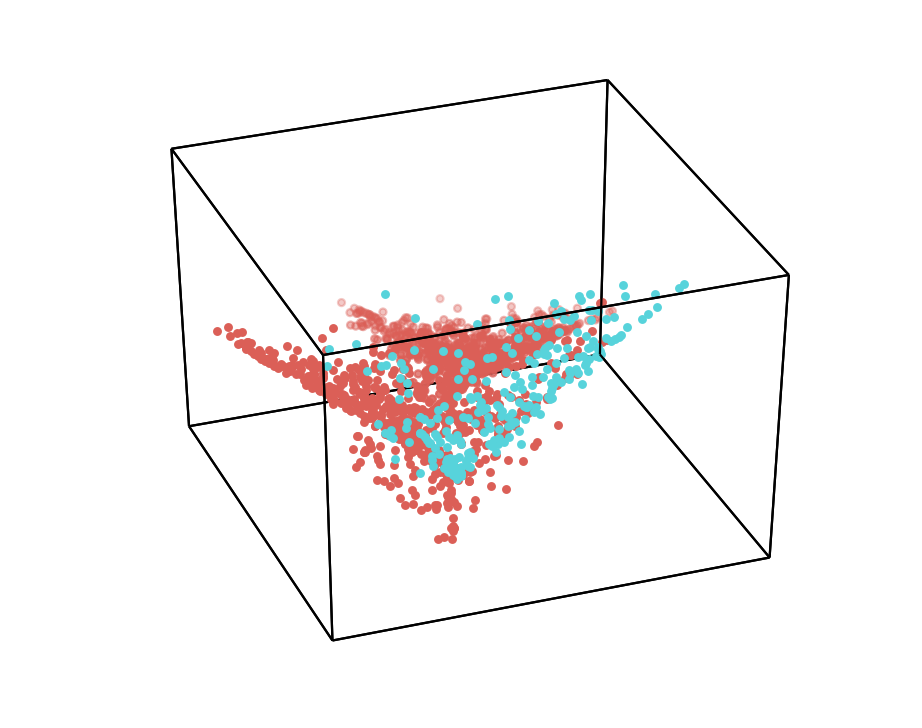

In [132]:
hyp.plot(np.vstack(data['topic_vector']),'.', ndims=3, hue = data['Action'])

In [117]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state = 0)
pca_result = pca.fit_transform(np.vstack(data['topic_vector']))

<IPython.core.display.Javascript object>


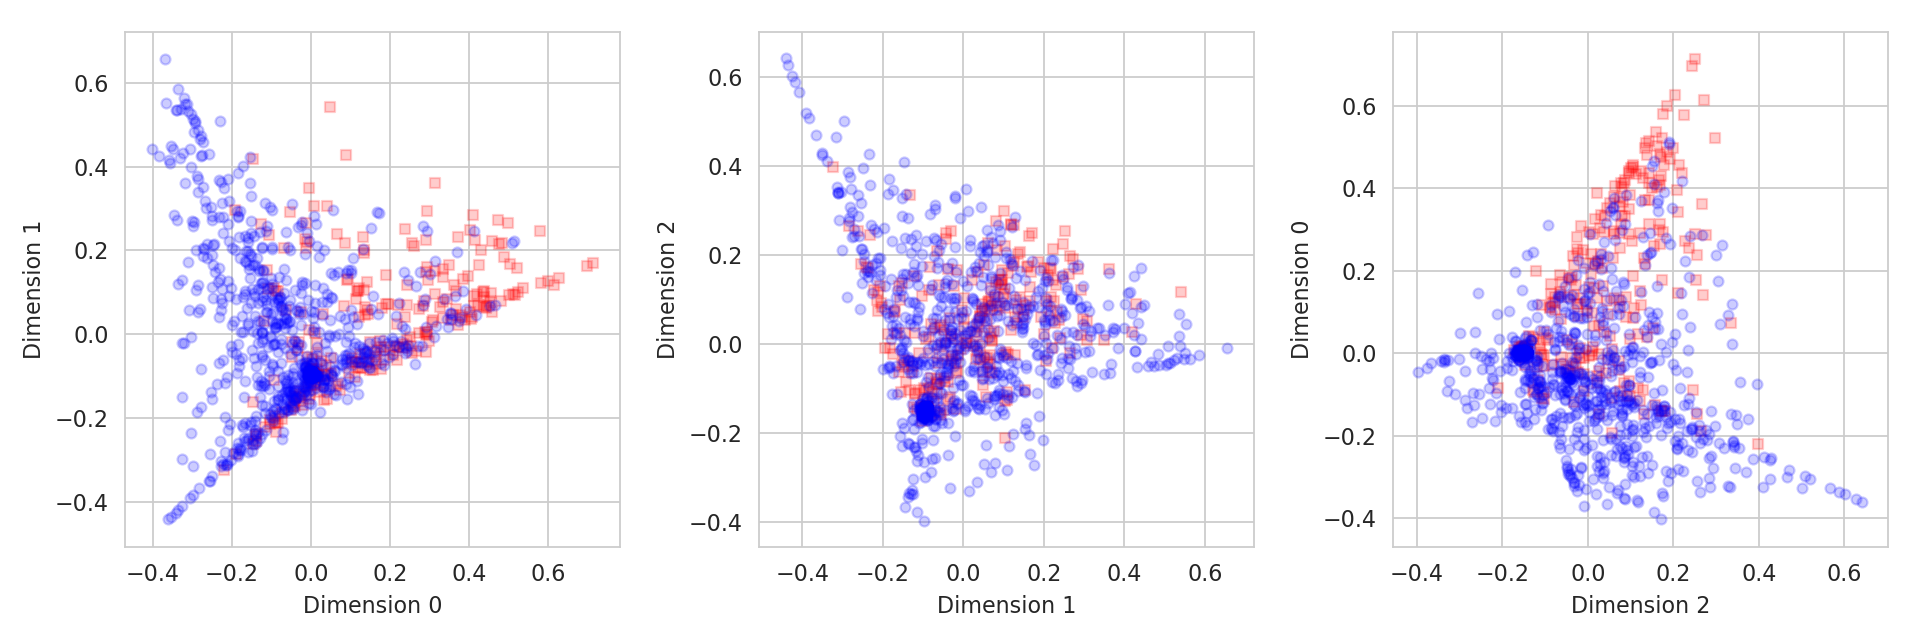

In [161]:
fig, ax = plt.subplots(1,3, figsize=[12,4])
for dim in [0,1,2]:
    xdim = 0+dim
    ydim = np.mod(1+dim,3)
    ax[dim].scatter(pca_result[data['Action'],xdim],pca_result[data['Action'],ydim], 
                    alpha = .2, s=20, c='r', marker = 's')
    ax[dim].scatter(pca_result[~data['Action'],xdim],pca_result[~data['Action'],ydim],
                    alpha = .2, s=20, c='b', marker = 'o')
    ax[dim].set(xlabel = 'Dimension %i'%xdim, ylabel = 'Dimension %i'%ydim)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


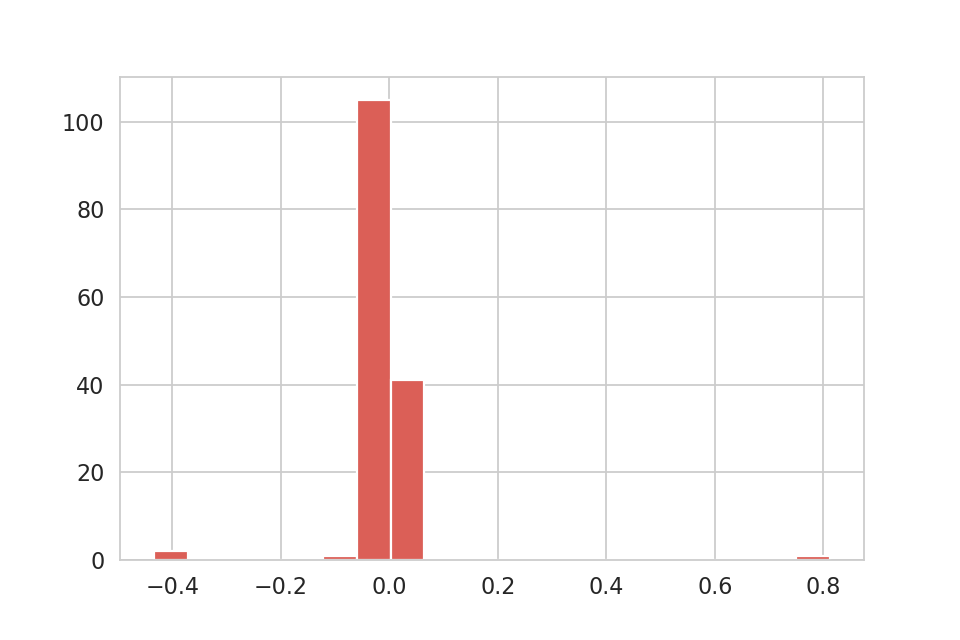

array([57])

In [179]:
fig, ax = plt.subplots(1,1)
ax.hist(pca.components_[0], 20)
strongest_topics = np.where(np.abs(pca.components_[0])>0.5)[0]
strongest_topics

In [180]:
# top_words = get_top_words(lda, words, 10);
[top_words[topic] for topic in strongest_topics]

[['bullets',
  'vehicles',
  'trigger',
  'concrete',
  'explosion',
  'stairwell',
  'rounds',
  'brakes',
  'photos',
  'trucks']]

## Plot topics by genre vs not-genre

<IPython.core.display.Javascript object>


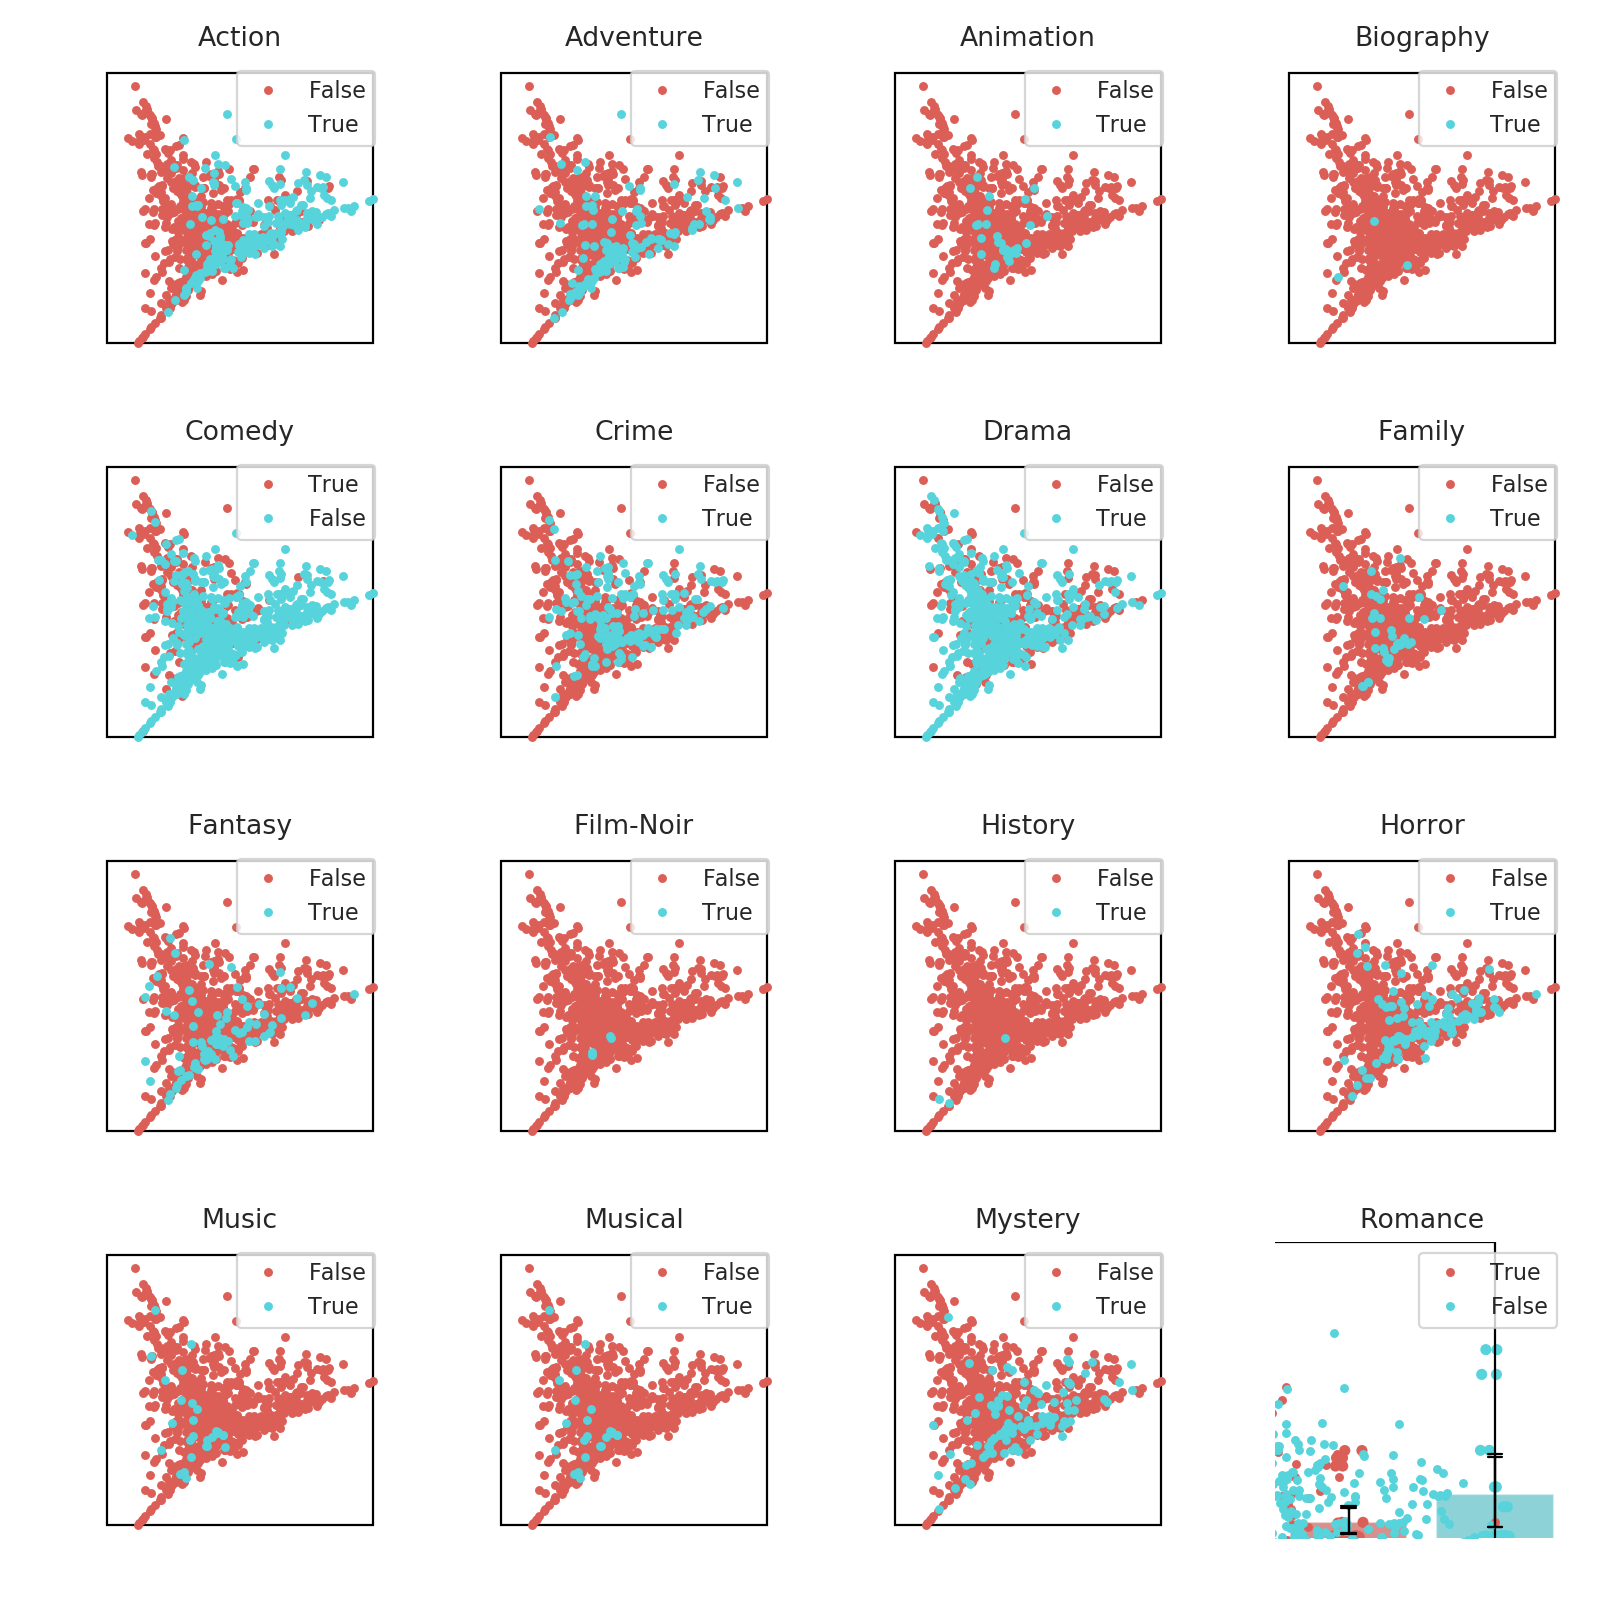

In [181]:
%matplotlib notebook
fig, ax = plt.subplots(4,4,figsize=[10,10])
ax = ax.flatten()
for ai, ax_current in enumerate(ax):
    genre_choice = genres[ai]
    hyp.plot(np.vstack(data['topic_vector']), '.', ndims = 2, hue = data[genre_choice],
         legend=data[genre_choice].unique().tolist(), title = genre_choice, ax = ax_current)
plt.show()
# plt.savefig('/mnt/movie_space.pdf',bbox_inches='tight')

## Compute similarity between movie script and review

In [125]:
# Load data with movie review IDs

In [182]:
data_with_reviews = pd.read_csv('../data/data_with_imdb_info.csv',index_col=0,
                               dtype={'imdb_id': str})

In [183]:
data_with_reviews = data_with_reviews.query('has_review == True')
data_with_reviews.head()

,id,title,url,writers,genres,script,imdb_id,has_review
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,0114746,True
10,11,2001: A Space Odyssey,http://www.imsdb.com/scripts/2001-A-Space-Odys...,Stanley Kubrick;Arhur C. Clarke,Adventure;Sci-Fi,\n\n\t\t\t\t \n\t\t\t\t 2001: A SPACE OD...,0062622,True
19,20,8MM,http://www.imsdb.com/scripts/8MM.html,Andrew Kevin Walker,Mystery;Thriller,"\n\n\n ""8MM"", by Andrew Kevin Walker\n\n\n\n...",0134273,True
20,21,9,http://www.imsdb.com/scripts/9.html,Pamela Pettler;Shane Acker,Animation;Adventure;Drama;Fantasy;Sci-Fi,\n \n \n ...,0472033,True
52,53,Alone in the Dark,http://www.imsdb.com/scripts/Alone-in-the-Dark...,Elan Mastai;Michael Roesch,Action;Horror;Thriller,\n\n\n ALON...,0369226,True


In [205]:
movie_id = data_with_reviews['id'].values[52]
movie_dat = data_with_reviews.query('id == @movie_id')
title = movie_dat['title'].values[0]
script = wipe_formatting(movie_dat['script'].values[0])
imdb_id = movie_dat['imdb_id'].values[0]
print(title, imdb_id)
# movie_doc = nlp(script)
movie_vec = lda.transform(cv.transform([cleanup_text(script)]))
review_data = pd.read_csv('../data/review_data.csv',index_col=0,dtype={'imdb_id':str})
review_data = review_data.query('imdb_id == @imdb_id').copy().reset_index(drop=True)
print(review_data['sentiment'].value_counts())

Halloween: The Curse of Michael Myers 0113253
neg    18
pos    12
Name: sentiment, dtype: int64


In [206]:
review_sim_results = pd.DataFrame()
for ri,review_dat in review_data.iterrows():
    review_set = review_dat['set']
    review_sentiment = review_dat['sentiment']
    filename = glob.glob('../../aclImdb/%s/%s/%i_*.txt'%(
        review_set,review_sentiment,review_dat['review_id']))[0]
    review_vec = lda.transform(cv.transform([cleanup_text(wipe_formatting(
        open(filename, 'r+', encoding="utf-8").read()))]))
#     review_doc = nlp(u'%s'%wipe_formatting(open(filename, 'r+', encoding="utf-8").read()))
    review_sim = sklearn.metrics.pairwise.cosine_similarity(movie_vec,review_vec)[0][0]
    review_sim_results = review_sim_results.append(pd.DataFrame(
        [[movie_id,title,imdb_id,ri,review_set, review_sentiment,review_sim]]))
review_sim_results = review_sim_results.reset_index(drop=True)
review_sim_results.columns = ['movie_id','title','imdb_id','review_id',
                              'review_set','review_sentiment','similarity_to_movie']

<IPython.core.display.Javascript object>


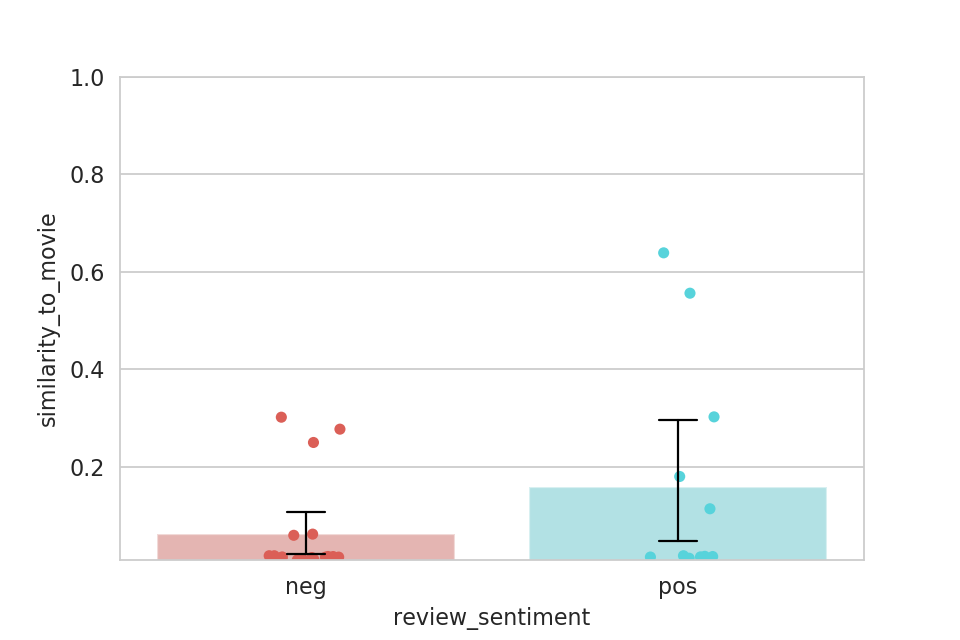

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [209]:
fig, ax = plt.subplots(1,1,figsize=[6,4])
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = .5, errwidth = 0, zorder = 0, ax=ax)
sns.stripplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
             zorder = 1, ax=ax)
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = 0, errwidth = 1, capsize = .1, errcolor = 'k', zorder = 2, ax=ax)
ax.set_ylim([min(review_sim_results.similarity_to_movie),1])
plt.show()

This might work!